<div style="text-align:center"> 
    <p style="font-size: 50px; margin-bottom: 0">Open Cluster Characterisation - M67</p>
    <p style="font-size: 20px; font-style: italic">ASTR 511 HW2 - Tom Wagg</p>
    <img src="M67_scienceblogsdotcom.jpeg" height="300px" style="border-radius: 100%">
</div>

In [170]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = "retina"
plt.style.use("dark_background")

from sklearn.mixture import GaussianMixture

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
Gaia.ROW_LIMIT = -1

# Part 1: Isolate cluster members
## Perform a Cone Search around the target

In [3]:
coord = SkyCoord(ra="08h51m03s", dec=11.49, unit=(u.degree, u.degree), frame='icrs')
radius = 1 * u.deg
j = Gaia.cone_search_async(coord, radius)

INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
r = j.get_results()
r = r.to_pandas().set_index("source_id")

In [154]:
# didn't use this in the end but tracking the interesting columns for me
columns=["dist", "source_id", "ra", "dec", "ra_error", "dec_error",
         "parallax", "parallax_error", "pmra", "pmra_error", "pmdec", "pmdec_error",
         "phot_g_mean_mag", "phot_bp_mean_mag", "phot_rp_mean_mag", "a_g_val"]

In [6]:
r

,solution_id,DESIGNATION,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist
source_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
598889556854572672,1635721458409799680,Gaia DR2 598889556854572672,1176460461,2015.5,132.762456,0.039452,11.495085,0.035029,0.782290,0.056015,13.965704,-2.234006,0.118945,1.268996,0.119216,-0.424627,-0.041809,-0.227167,0.221472,-0.236372,0.605028,-0.785085,-0.172691,0.429099,-0.792799,284,0,283,1,1.416685,312.040192,0.071504,0.670944,31,False,15.272051,1.566975,0.007197,-0.031739,33,11,0.154670,0,35,True,301,13627.542336,4.463750,3052.935791,15.352322,31,6969.172180,10.601081,657.402039,15.743435,32,9698.114186,16.245186,596.983887,14.795201,1.223059,0,0.948234,0.391113,0.557120,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.991335,31.712607,131.984014,-5.931574,100001,5364.852539,5282.0,5785.282227,0.3253,0.1829,0.4847,0.1633,0.1040,0.2490,200111,1.106147,0.951217,1.141121,0.913170,0.771704,1.054637,https://gea.esac.esa.int/data-server/datalink/...,0.005091
598889552564701312,1635721458409799680,Gaia DR2 598889552564701312,939420882,2015.5,132.756219,1.221686,11.493655,1.171564,-0.103058,1.686537,-0.061106,-1.034997,3.147085,-4.892142,2.662119,-0.730931,-0.440083,-0.549058,0.605474,0.440029,0.787744,-0.886647,0.573219,-0.264762,-0.810182,251,0,245,6,1.886506,283.004517,0.000000,0.000000,31,False,0.028019,1.267906,0.175035,-0.035836,30,10,3.723985,0,32,False,272,103.505743,0.941255,109.965652,20.650955,18,37.943370,7.723823,4.912512,21.403549,27,131.420743,7.634628,17.213772,19.465260,1.636277,0,1.938290,0.752594,1.185696,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.989833,31.706462,131.978491,-5.934610,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,0.007166
598889449480994944,1635721458409799680,Gaia DR2 598889449480994944,299968321,2015.5,132.752334,0.969877,11.486227,0.840157,3.825357,1.225824,3.120640,-14.772357,2.131818,-15.708994,2.144506,-0.506023,-0.326557,-0.289459,0.280931,-0.120730,0.577735,-0.809866,0.027426,0.294512,-0.717973,240,0,238,2,0.621057,245.973740,0.000000,0.000000,31,False,0.030772,1.599588,0.179344,0.000856,29,12,2.563867,0,31,False,260,104.205421,0.786280,132.529739,20.643641,21,82.712523,7.447978,11.105366,20.557461,21,67.757496,8.491827,7.979142,20.184526,1.443975,0,0.372934,-0.086180,0.459114,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.995865,31.699

### Plot out the proper motions

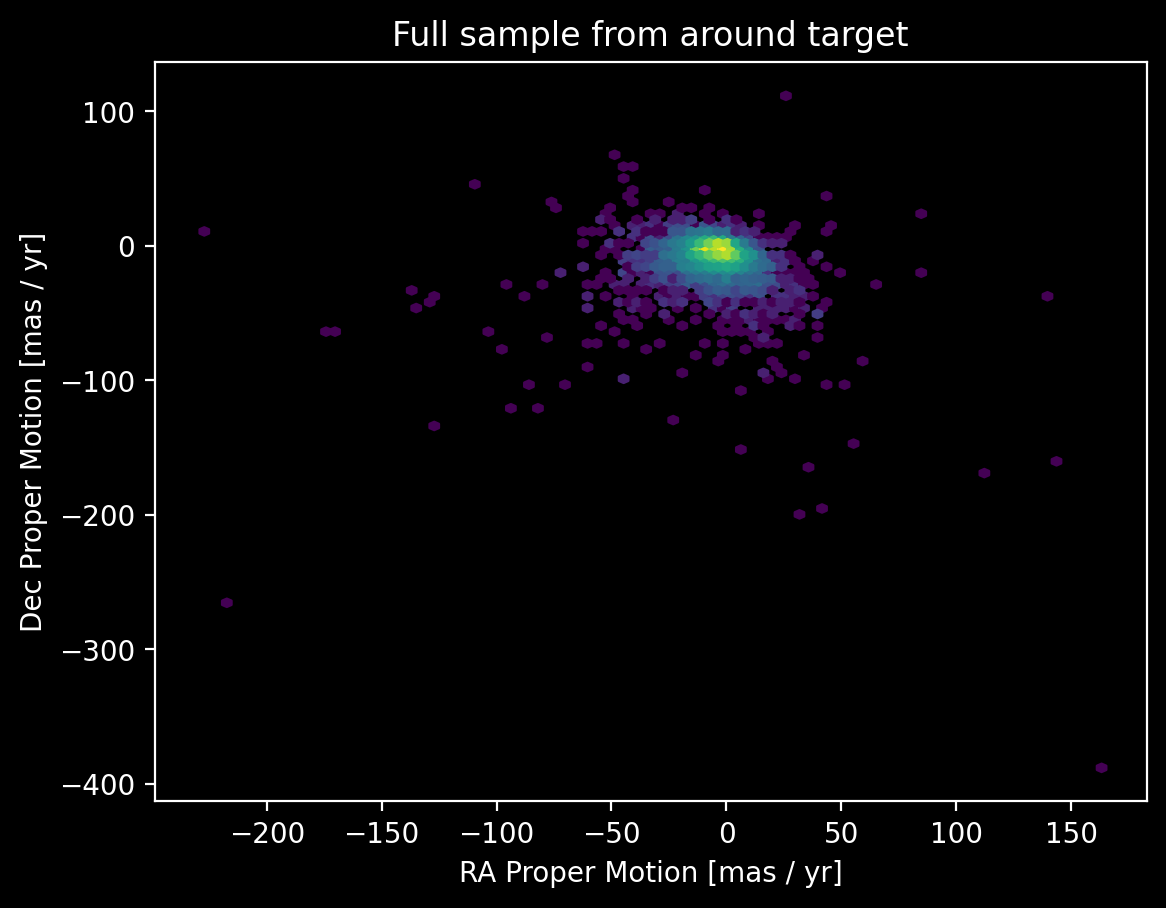

In [171]:
plt.hexbin(r["pmra"], r["pmdec"], gridsize=100, bins="log")
plt.xlabel("RA Proper Motion [mas / yr]")
plt.ylabel("Dec Proper Motion [mas / yr]")
plt.title("Full sample from around target")
plt.show()

## Simple quality cuts
Now we can apply some simple quality cuts. For this I have just applied
- Ensure there are no NaNs in the proper motion (basically avoid bad measurements I think)
- Fix a good parallax/parallax error radius to keep only the ones with a good measurement
- Restrict the proper motion to reasonably slow velocities to get rid of outliers

In [21]:
motion_not_nan = (~np.isnan(r["pmra"])) & (~np.isnan(r["pmdec"]))
good_parallax = (r["parallax"] / r["parallax_error"]) > 5
not_too_fast = (np.abs(r["pmra"]) < 30) & (np.abs(r["pmdec"]) < 30)

quality_cut = motion_not_nan & good_parallax & not_too_fast
len(r), len(r[quality_cut])

(19580, 5272)

This reduces the data to about a quarter of its original size

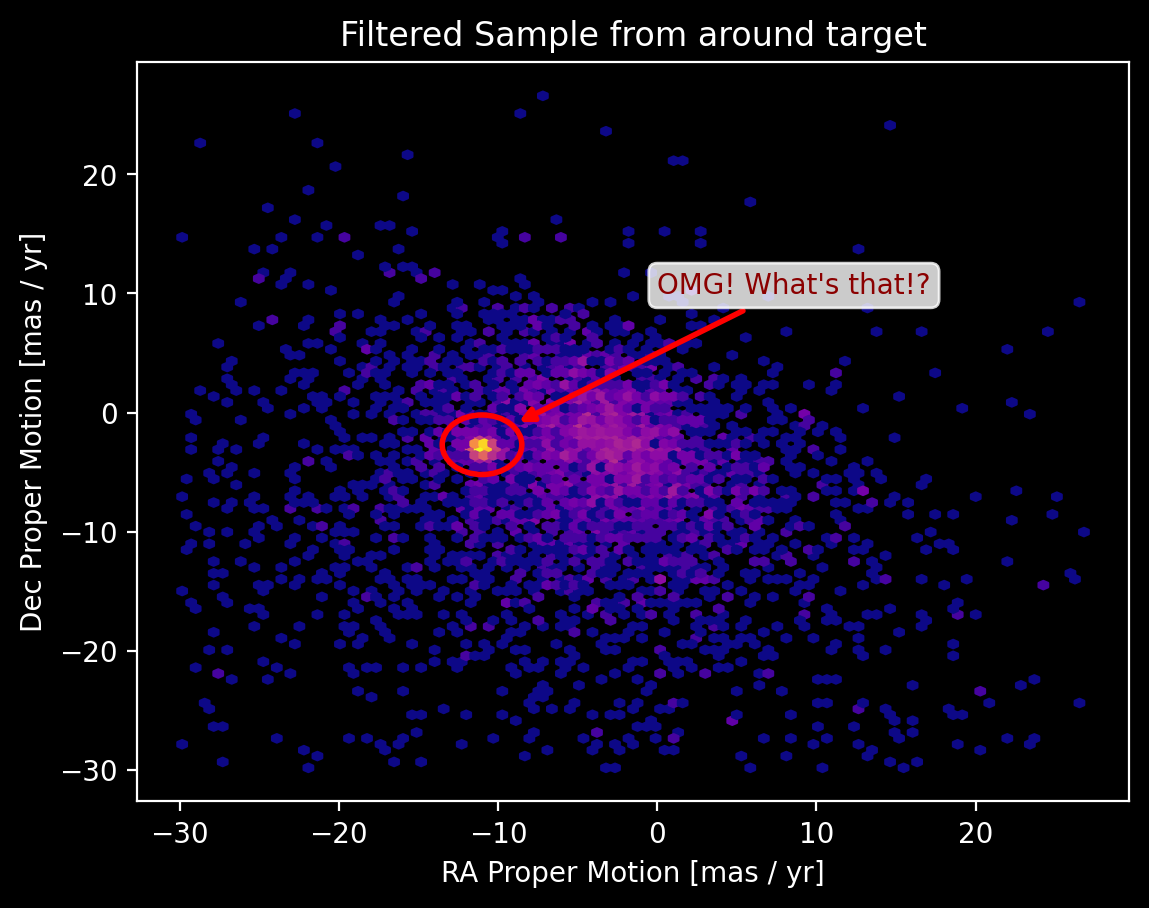

In [213]:
plt.hexbin(r["pmra"][quality_cut], r["pmdec"][quality_cut], gridsize=100, bins="log", cmap="plasma")
plt.xlabel("RA Proper Motion [mas / yr]")
plt.ylabel("Dec Proper Motion [mas / yr]")
plt.title("Filtered Sample from around target")
plt.gca().add_artist(plt.Circle((-11, -2.7), 2.5, facecolor="none", edgecolor="red", lw=2))
plt.annotate("OMG! What's that!?", xy=(-9, -1), xytext=(0, 10), color="darkred",
             bbox=dict(boxstyle="round", color="white", alpha=0.8),
             arrowprops=dict(arrowstyle="-|>", color="red", lw=2))
plt.show()

Look! We can see a cluster!!! So cool :D Now let's go identify which stars belong to it properly.

## Apply GMM to isolate cluster stars
Shoutout to Andy C and Stephen for teaching me how to do this in their class last year

The general plan here:
1. Fit a series of GMMs with a range of different `n_components`
2. Pick the one with the lowest BIC
3. For chosen model, predict the probability that each star belongs to the cluster (I'm assuming the cluster is the most compact of the different Gaussians)
4. ...Profit?

In [156]:
# I stole this from an example in the scikit-learn docs which I have now lost
# it plots the ellipses representing the gaussians that are fit roughly
def make_ellipses(gmm, ax):
    for n in range(gmm.n_components):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=f"C{n + 1}"
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.25)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

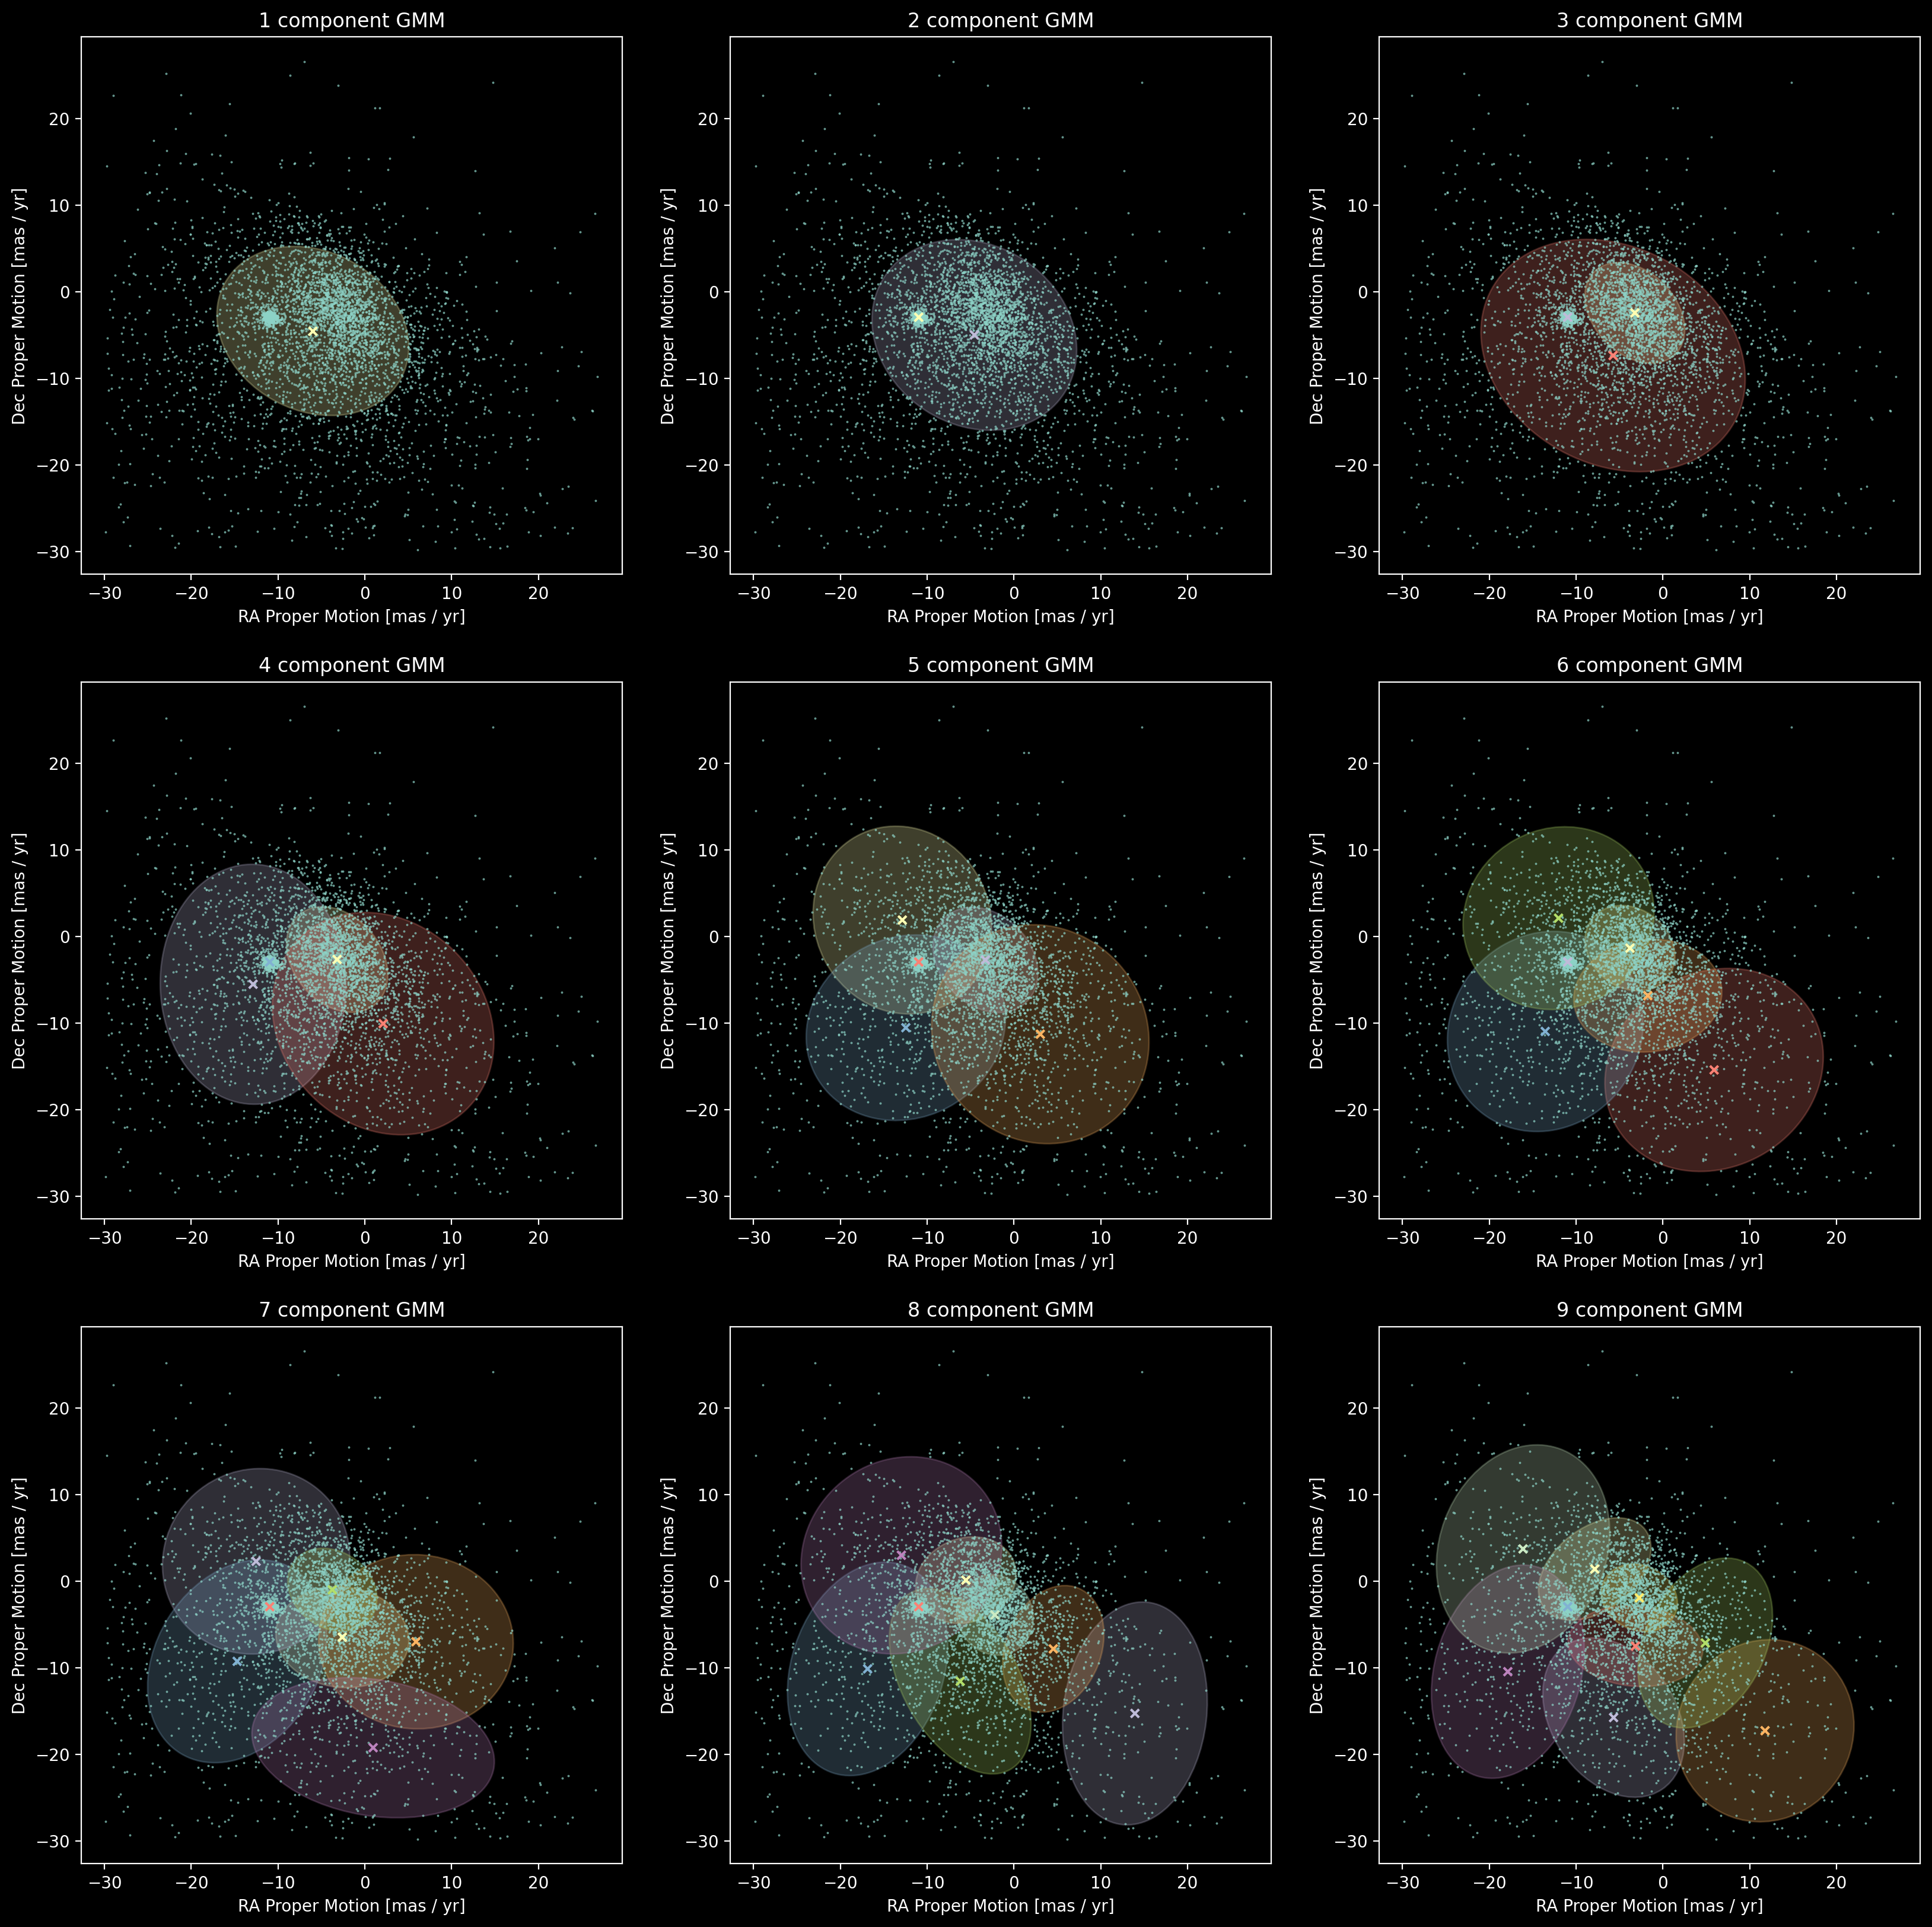

In [173]:
n_components_list = range(1, 10)

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
flat_axes = axes.ravel()

bics = [None for i in n_components_list]
mixes = [None for i in n_components_list]

X = r[["pmra", "pmdec"]][quality_cut].values
for i, n_components in enumerate(n_components_list):
    mixes[i] = GaussianMixture(n_components=n_components)
    mixes[i].fit(X)

    bics[i] = mixes[i].bic(X)

    make_ellipses(mixes[i], flat_axes[i])

    flat_axes[i].scatter(*X.T, s=0.1)#, c=mix.predict(X))
    flat_axes[i].scatter(*mixes[i].means_.T, s=25, marker="x",
                c=[f"C{j + 1}" for j in range(n_components)])
    flat_axes[i].set_title(f"{n_components} component GMM")


for ax in flat_axes:
    ax.set_xlabel("RA Proper Motion [mas / yr]")
    ax.set_ylabel("Dec Proper Motion [mas / yr]")

plt.show()

By eye we can see the cluster pop out as soon as we have 2 components - but which model is best? BIC time!

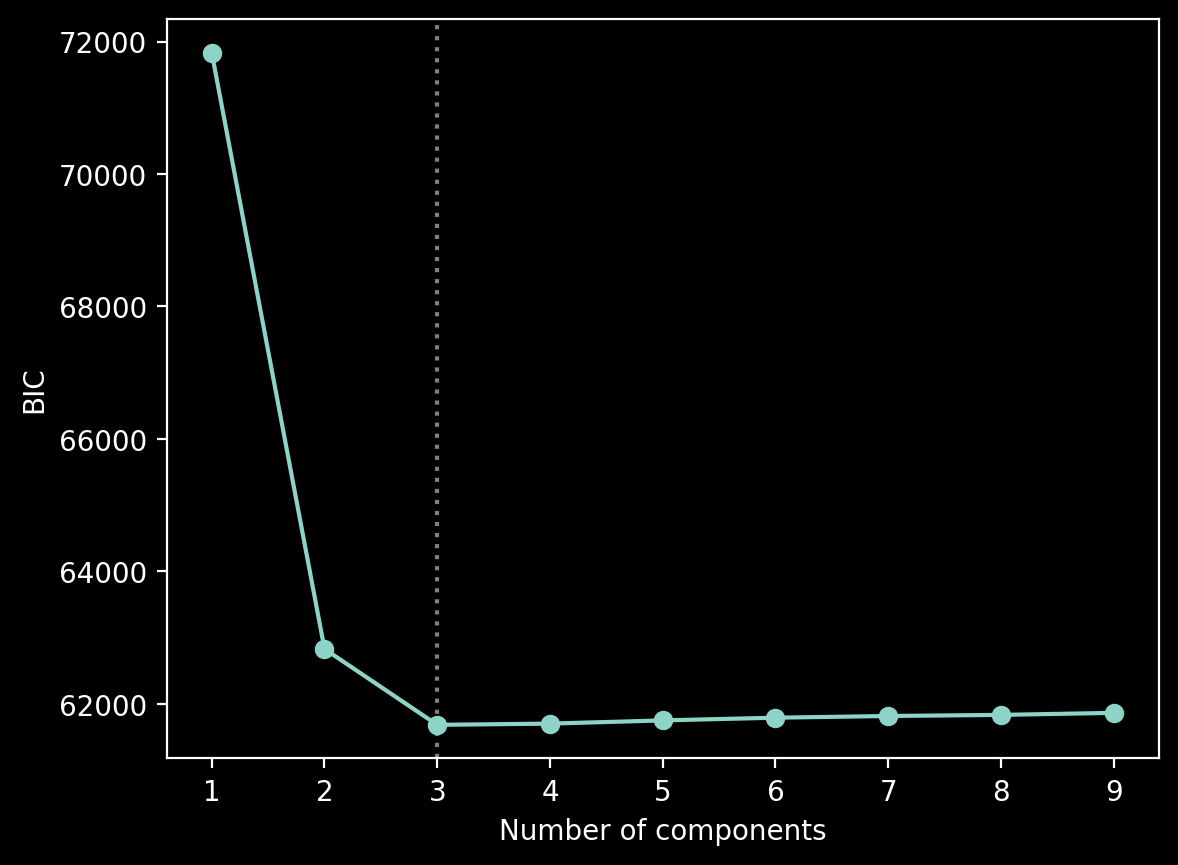

In [215]:
plt.plot(n_components_list, bics, marker="o")
plt.xlabel("Number of components")
plt.ylabel("BIC")
plt.axvline(n_components_list[np.argmin(bics)], color="grey", linestyle="dotted", zorder=-1)
plt.show()

So it seems like our best mixture model has 3 components, no need for more than that. Great, now let's identify which of the components is our cluster (assuming that it is the smallest one)

In [193]:
best_mix = mixes[np.argmin(bics)]

# the eigenvalues tell you the length of the primary and secondary axis of the ellipse so product is area
ellipse_areas = [np.product(np.linalg.eigh(best_mix.covariances_[i])[0]) for i in range(best_mix.n_components)]
cluster_comp = np.argmin(ellipse_areas)

In [200]:
# get a probability that each star is part of the cluster
probs = best_mix.predict_proba(X)[:, cluster_comp]

Conservatively just say a start needs a 10% chance of being in the cluster to make it through our cut. Let's see how that looks

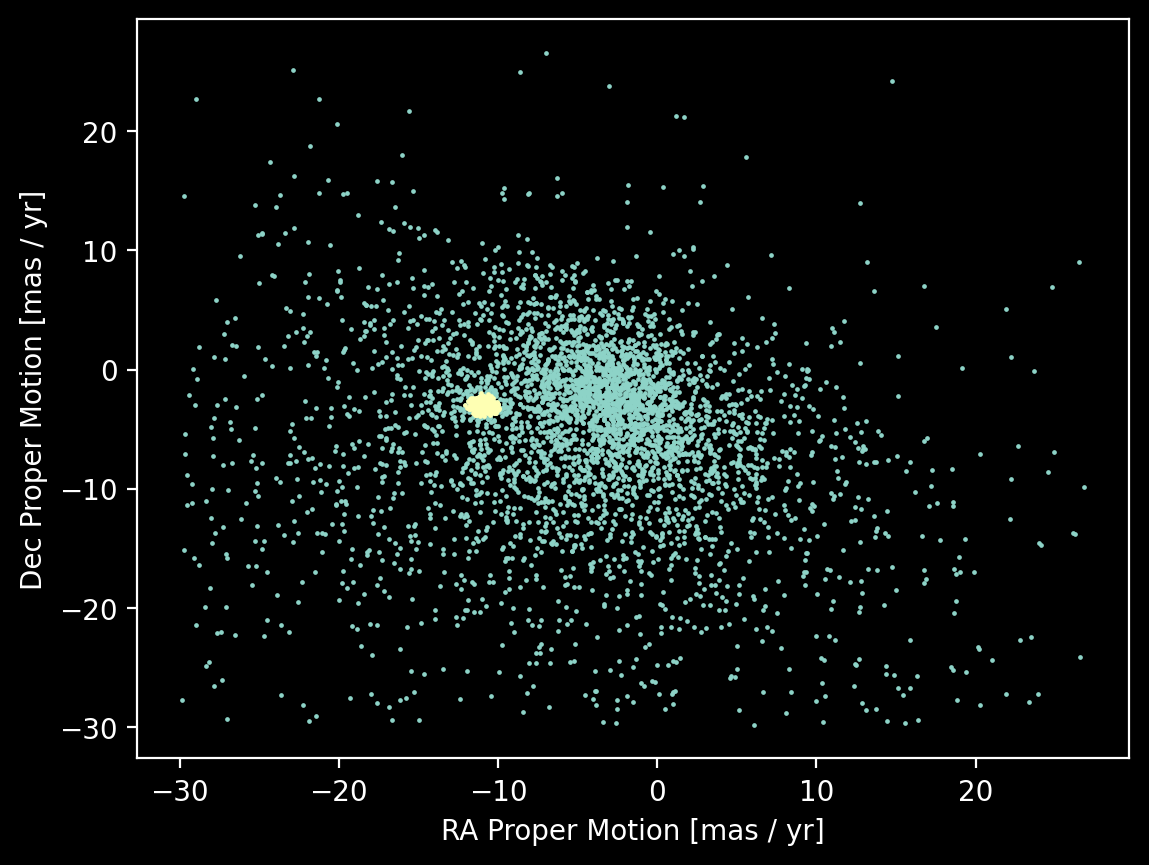

In [202]:
plt.scatter(*X.T, s=0.5)
plt.scatter(*X[probs > 0.1].T, s=0.5)
plt.xlabel("RA Proper Motion [mas / yr]")
plt.ylabel("Dec Proper Motion [mas / yr]")
plt.show()

Looking good! I see a cluster :D

# Part 2: Characterisation